## <div style="text-align: center"> RSNA 2023 Abdominal Trauma Detection </div>
### <div style="text-align: center"> Detect and classify traumatic abdominal injuries </div>
---


## 📂 Data

<center>

| Filename | Description |
| - | - |
|  |  |
|  |  |
|  |  |

</center>


# 0 | ⚙ setup


In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib # NiBabelの導入の確認　エラーが出なければ成功

from tqdm import tqdm

In [2]:
# file paths
data_dir = Path(r"D:\RSNA2023\data")

train_data_path = data_dir / "train.csv"
train_dicom_tags_path = data_dir / "train_dicom_tags.parquet"
train_series_path = data_dir / "train_series_meta.csv"
train_images_dir = data_dir / "train_images"
train_images_labels_path = data_dir / "image_level_labels.csv"
segmentations_dir = data_dir / "segmentations"
submission_path = data_dir / "sample_submission.csv"


In [3]:
train_data = pd.read_csv(train_data_path)

display(train_data.info())
display(train_data.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)
memory usage: 368.9 KB


None

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1
5,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1
6,10082,1,0,1,0,1,0,0,1,0,0,1,0,0,0
7,10104,1,0,1,0,1,0,0,1,0,0,1,0,0,0
8,10105,1,0,1,0,1,0,0,1,0,0,1,0,0,0
9,10124,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [4]:
submission = pd.read_csv(submission_path)

display(submission.head(10))


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [5]:
train_series = pd.read_csv(train_series_path)

display(train_series.info())
display(train_series.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        4711 non-null   int64  
 1   series_id         4711 non-null   int64  
 2   aortic_hu         4711 non-null   float64
 3   incomplete_organ  4711 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 147.3 KB


None

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0
5,10026,42932,122.00,0
6,10051,17486,345.00,0
7,10051,50172,151.00,0
8,10065,37324,163.00,0
9,10065,46839,303.00,0


In [6]:
train_series["image_num"] = None
for row in tqdm(train_series.itertuples(), total=train_series.shape[0]):
    images_dir = train_images_dir / str(row.patient_id) / str(row.series_id)
    train_series.loc[row.Index, "image_num"] = len(
        [image_path for image_path in images_dir.glob("*.png")]
    )


100%|██████████| 4711/4711 [00:07<00:00, 642.53it/s] 


In [7]:
train_patient_info = pd.concat(
    [
        train_series.groupby("patient_id").agg(
            incomplete_organ_num=("incomplete_organ", "sum"),
            ct_scan_count=("series_id", "count"),
            aortic_hu_mean=("aortic_hu", "mean"),
            aortic_hu_max=("aortic_hu", "max"),
            aortic_hu_min=("aortic_hu", "min"),
            image_num_mean=("image_num", "mean"),
            image_num_max=("image_num", "max"),
            image_num_min=("image_num", "min"),
        ),
        train_data.set_index("patient_id").sort_index()
    ],
    axis=1
)

display(train_patient_info.info())
display(train_patient_info.head(10))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3147 entries, 19 to 65508
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   incomplete_organ_num   3147 non-null   int64  
 1   ct_scan_count          3147 non-null   int64  
 2   aortic_hu_mean         3147 non-null   float64
 3   aortic_hu_max          3147 non-null   float64
 4   aortic_hu_min          3147 non-null   float64
 5   image_num_mean         3147 non-null   float64
 6   image_num_max          3147 non-null   int64  
 7   image_num_min          3147 non-null   int64  
 8   bowel_healthy          3147 non-null   int64  
 9   bowel_injury           3147 non-null   int64  
 10  extravasation_healthy  3147 non-null   int64  
 11  extravasation_injury   3147 non-null   int64  
 12  kidney_healthy         3147 non-null   int64  
 13  kidney_low             3147 non-null   int64  
 14  kidney_high            3147 non-null   int64  
 15  li

None

,incomplete_organ_num,ct_scan_count,aortic_hu_mean,aortic_hu_max,aortic_hu_min,image_num_mean,image_num_max,image_num_min,bowel_healthy,bowel_injury,...,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
patient_id,,,,,,,,,,,,,,,,,,,,,
19,0,1,174.000,174.0,174.00,673.0,673,673,1,0,...,1,0,0,1,0,0,1,0,0,0
26,0,2,178.000,255.0,101.00,176.5,183,170,1,0,...,1,0,0,1,0,0,1,0,0,0
33,0,1,105.000,105.0,105.00,205.0,205,205,0,1,...,1,0,0,0,1,0,1,0,0,1
43,1,2,90.875,127.0,54.75,138.0,216,60,0,1,...,1,0,0,1,0,0,1,0,0,1
96,0,1,134.000,134.0,134.00,259.0,259,259,1,0,...,1,0,0,1,0,0,1,0,0,0
122,0,2,156.000,194.0,118.00,150.0,196,104,1,0,...,1,0,0,1,0,0,1,0,0,0
156,0,1,206.000,206.0,206.00,188.0,188,188,1,0,...,1,0,0,1,0,0,1,0,0,0
187,0,1,129.000,129.0,129.00,116.0,116,116,1,0,...,1,0,0,1,0,0,1,0,0,0
201,0,1,485.000,485.0,485.00,707.0,707,707,1,0,...,1,0,0,1,0,0,1,0,0,0


In [8]:
train_dicom_tags = pd.read_parquet(train_dicom_tags_path)

display(train_dicom_tags.info())
display(train_dicom_tags.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510373 entries, 0 to 1510372
Data columns (total 35 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   BitsAllocated               1510373 non-null  int64  
 1   BitsStored                  1510373 non-null  int64  
 2   Columns                     1510373 non-null  int64  
 3   ContentDate                 1510373 non-null  object 
 4   ContentTime                 1510373 non-null  object 
 5   FrameOfReferenceUID         1510373 non-null  object 
 6   HighBit                     1510373 non-null  int64  
 7   ImageOrientationPatient     1510373 non-null  object 
 8   ImagePositionPatient        1510373 non-null  object 
 9   InstanceNumber              1510373 non-null  int64  
 10  KVP                         1510373 non-null  float64
 11  PatientID                   1510373 non-null  object 
 12  PatientPosition             1510373 non-null  object 
 1

None

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path,RescaleType
0,16,16,512,20230722,003306.881589,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1459.20]",532,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.532,1.2.840.10008.1.2.5,train_images/49954/41479/532.dcm,nan
1,16,16,512,20230722,003303.279137,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1474.40]",513,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.513,1.2.840.10008.1.2.5,train_images/49954/41479/513.dcm,nan
2,16,16,512,20230722,003343.090736,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1310.40]",718,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.718,1.2.840.10008.1.2.5,train_images/49954/41479/718.dcm,nan
3,16,16,512,20230722,003252.960345,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1520.00]",456,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.456,1.2.840.10008.1.2.5,train_images/49954/41479/456.dcm,nan
4,16,16,512,20230722,003155.059398,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1756.00]",161,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.161,1.2.840.10008.1.2.5,train_images/49954/41479/161.dcm,nan
5,16,16,512,20230722,003358.562591,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1244.00]",801,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.801,1.2.840.10008.1.2.5,train_images/49954/41479/801.dcm,nan
6,16,16,512,20230722,003333.915039,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1346.40]",673,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.673,1.2.840.10008.1.2.5,train_images/49954/41479/673.dcm,nan
7,16,16,512,20230722,003226.785417,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1628.00]",321,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.321,1.2.840.10008.1.2.5,train_images/49954/41479/321.dcm,nan
8,16,16,512,20230722,003354.383108,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1261.60]",779,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.779,1.2.840.10008.1.2.5,train_images/49954/41479/779.dcm,nan
9,16,16,512,20230722,003322.258080,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1396.80]",610,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.610,1.2.840.10008.1.2.5,train_images/49954/41479/610.dcm,nan


In [9]:
train_images_labels = pd.read_csv(train_images_labels_path)

display(train_images_labels.columns)
display(train_images_labels.head(10))


Index(['patient_id', 'series_id', 'instance_number', 'injury_name'], dtype='object')

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
5,10004,21057,367,Active_Extravasation
6,10004,21057,368,Active_Extravasation
7,10004,21057,369,Active_Extravasation
8,10004,21057,370,Active_Extravasation
9,10004,21057,371,Active_Extravasation


In [10]:
segmentation_files = [file for file in segmentations_dir.glob("*.nii")]

segmentations = pd.DataFrame(
    [segmentation_files], index=["filename"],
    columns=[int(file.stem) for file in segmentation_files]
).T
segmentations.index.name = "patient_id"
segmentations.sort_index(inplace=True)
segmentations["image_width"] = None
segmentations["image_height"] = None
segmentations["image_num"] = None

# CTスキャン画像の枚数を確認
for row in tqdm(segmentations.itertuples(), total=segmentations.shape[0]):
    nii_img = nib.load(row.filename)
    data = nii_img.get_fdata()
    segmentations.loc[row.Index, "image_width"] = data.shape[0]
    segmentations.loc[row.Index, "image_height"] = data.shape[1]
    segmentations.loc[row.Index, "image_num"] = data.shape[2]

display(segmentations.head(10))


100%|██████████| 206/206 [03:59<00:00,  1.16s/it]


,filename,image_width,image_height,image_num
patient_id,,,,
137,D:\RSNA2023\data\segmentations\137.nii,512,512,718
397,D:\RSNA2023\data\segmentations\397.nii,512,512,64
525,D:\RSNA2023\data\segmentations\525.nii,512,512,203
527,D:\RSNA2023\data\segmentations\527.nii,512,512,352
778,D:\RSNA2023\data\segmentations\778.nii,512,512,751
1201,D:\RSNA2023\data\segmentations\1201.nii,512,512,252
4123,D:\RSNA2023\data\segmentations\4123.nii,512,512,175
4622,D:\RSNA2023\data\segmentations\4622.nii,512,512,192
4759,D:\RSNA2023\data\segmentations\4759.nii,512,512,861


In [11]:
# Only trauma columns were selected to identify trauma trends.
injury_cols = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_low",
    "kidney_high",
    "liver_low",
    "liver_high",
    "spleen_low",
    "spleen_high",
    "any_injury"
]

aortic_cols = [
    "aortic_hu_mean",
    "aortic_hu_min", 
    "aortic_hu_max"
]

image_num_cols = [
    "image_num_mean",
    "image_num_min",
    "image_num_max",
]


# 📊 Visualize Datas with Graph

## 🩸Aortic

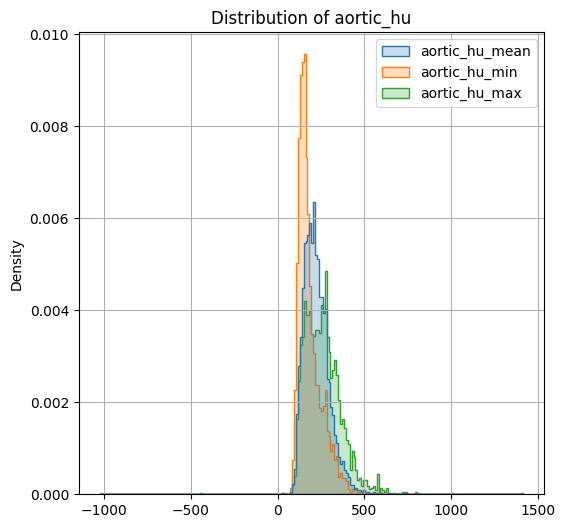

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Distribution of aortic_hu")

sns.histplot(
    data=train_patient_info.loc[:, aortic_cols],
    element="step",
    stat="density",
    common_norm=False,
    ax=ax
)

ax.grid()

plt.close()
display(fig)


In [13]:
# get the presence of trauma.
train_patient_info["has_injury"] = train_patient_info.loc[
    :, injury_cols
].sum(axis=1)

train_patient_info["has_injury"].mask(
    train_patient_info["has_injury"] > 0, 1, inplace=True
)


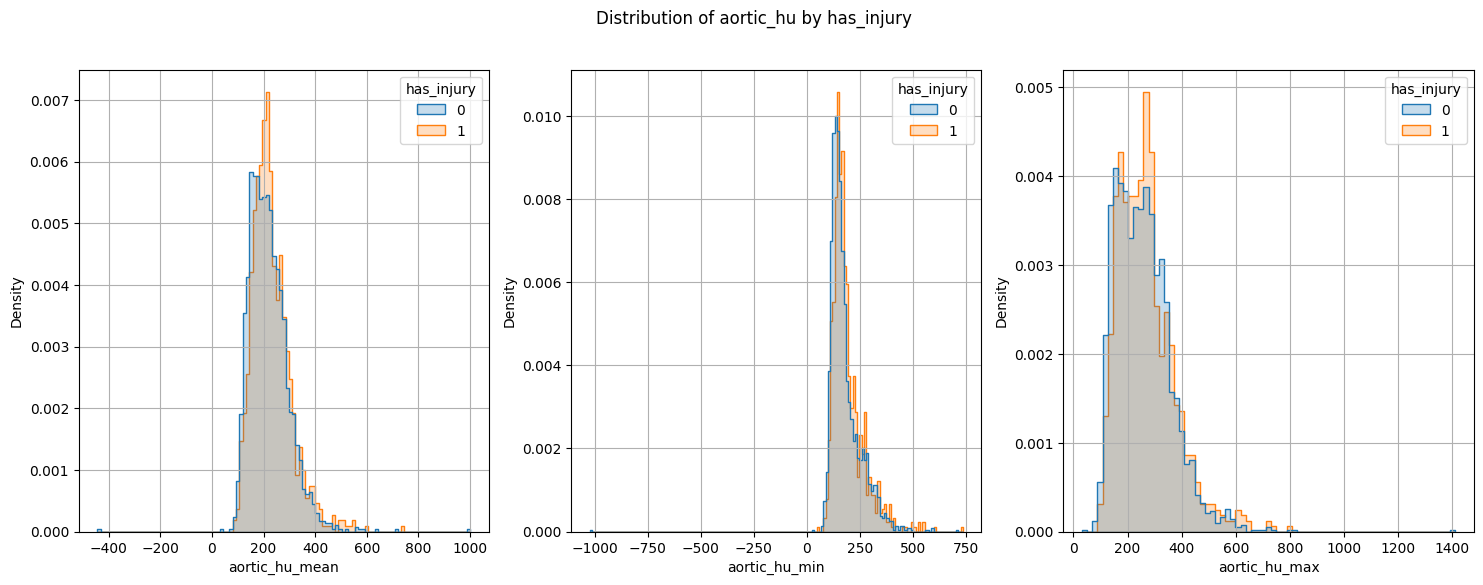

In [14]:
fig, axes = plt.subplots(1, len(aortic_cols), figsize=(6*len(aortic_cols), 6))
fig.suptitle("Distribution of aortic_hu by has_injury")

for i, col in enumerate(aortic_cols):

    sns.histplot(
        data=train_patient_info,
        x=col,
        hue="has_injury",
        element="step",  # ステップ状のヒストグラム
        stat="density",  # 分布の密度を表示
        common_norm=False,  # 各カテゴリごとに個別の密度を表示
        ax=axes[i]
    )
    axes[i].grid()

plt.close()
display(fig)


# 📷 Image size Analysis

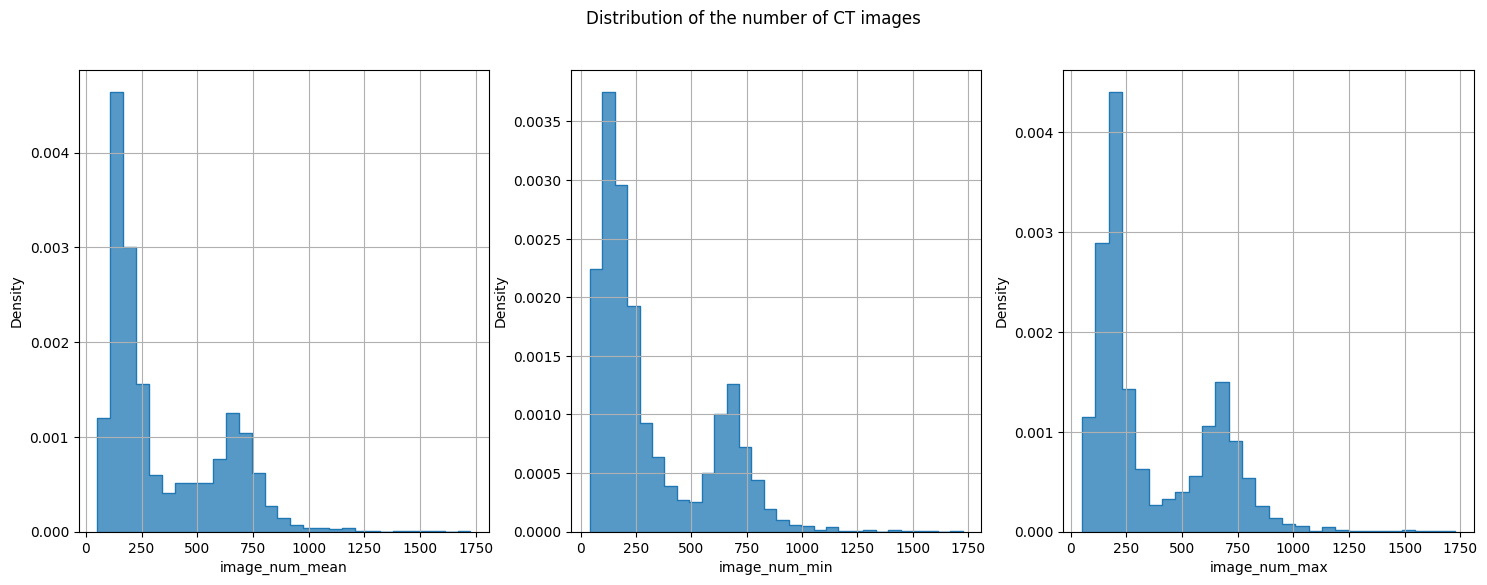

In [15]:
fig, axes = plt.subplots(1, len(aortic_cols), figsize=(6*len(aortic_cols), 6))
fig.suptitle("Distribution of the number of CT images")

for i, col in enumerate(image_num_cols):

    sns.histplot(
        data=train_patient_info,
        x=col,
        # hue="has_injury",
        element="step",
        stat="density",
        common_norm=False,
        ax=axes[i]
    )
    axes[i].grid()

plt.close()
display(fig)


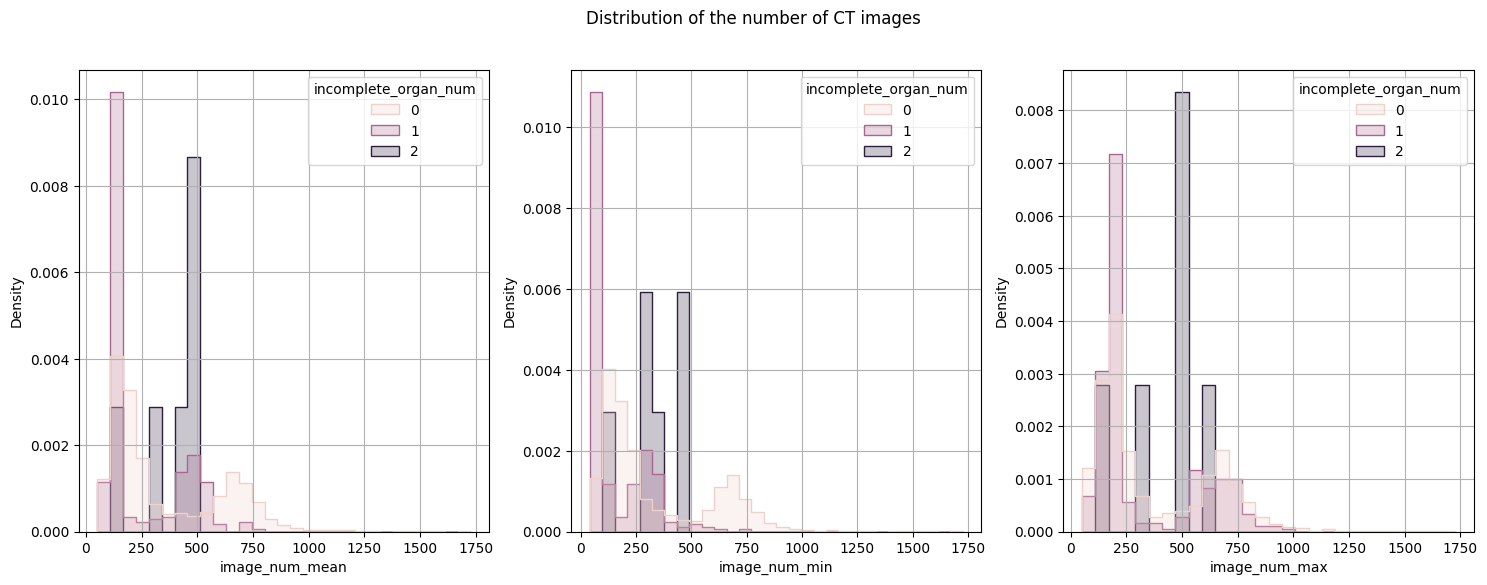

In [16]:
fig, axes = plt.subplots(1, len(aortic_cols), figsize=(6*len(aortic_cols), 6))
fig.suptitle("Distribution of the number of CT images")

for i, col in enumerate(image_num_cols):

    sns.histplot(
        data=train_patient_info,
        x=col,
        hue="incomplete_organ_num",
        element="step",
        stat="density",
        common_norm=False,
        ax=axes[i]
    )
    axes[i].grid()

plt.close()
display(fig)


## ❤️‍🩹 injuries

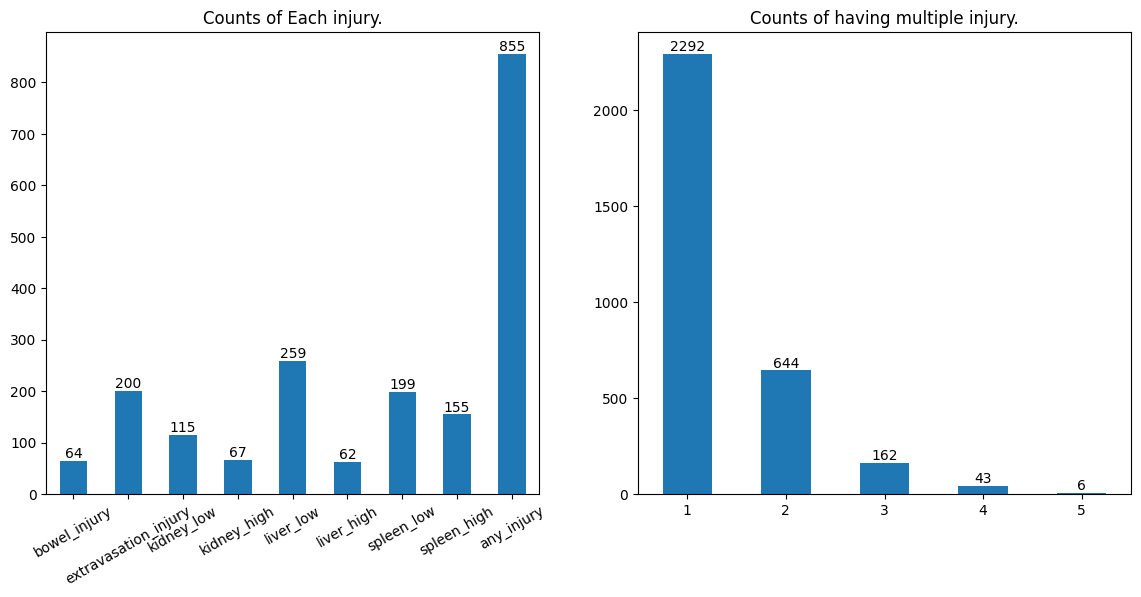

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train_data[injury_cols].sum().plot(ax=axes[0], kind="bar")

for bars in axes[0].containers:
    axes[0].bar_label(bars)

axes[0].set_xticklabels(injury_cols, rotation=30)
axes[0].set_title("Counts of Each injury.")

train_data[injury_cols].sum(axis=1).value_counts().sort_index().plot(ax=axes[1], kind="bar")

for bars in axes[1].containers:
    axes[1].bar_label(bars)

axes[1].set_xticklabels(np.arange(1, 6), rotation=0)
axes[1].set_title("Counts of having multiple injury.")

plt.close()
display(fig)
